## M-Kopa Data Science Hiring Exercise

Through this exercise I'll perform

0. Import data, convert all columns to numeric category, and create some basic new variables
1. Visualize all variables and correlations
2. Train and evaluate regression model to predict AmountPaid360 variable
3. Train and evaluate classification model to predict LoanStatus variable
4. Miscellaneous tasks such as randomized grid search with cross validation for best parameters, comparison of several models per task, splitting data into train and test, 

Solving a real problem for task at hand I imagine I'd expand further in following directions

0. Loan portfolio is probably larger dataset than just ~9k which should improve accuracy overall
1. Hopefully there would be more details from other sources especially about the loan owner, her/his credit score, internal rating, number and type of accounts, days in delay, collection activities, etc
2. Include more models such xgboost, svm, deep learning, etc
3. Work a lot more on excluding outliers, transforming certain variables, more detailed feature engineering
4. Focus on parameters optimization

In [1]:
# import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import seaborn as sns; sns.set(style="ticks", color_codes=True)

from math import sqrt
import os
import sys
import warnings
warnings.filterwarnings('ignore')
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
%matplotlib inline
p = print
p('Machine: {} {}\n'.format(os.uname().sysname,os.uname().machine))
p(sys.version)

Machine: Darwin x86_64

3.6.5 (v3.6.5:f59c0932b4, Mar 28 2018, 03:03:55) 
[GCC 4.2.1 (Apple Inc. build 5666) (dot 3)]


In [2]:
#import CSV file
dat = pd.read_csv("/Users/Dovla/Downloads/Data Science assessment.csv", parse_dates=[5])
print(dat.info())
dat.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9195 entries, 0 to 9194
Data columns (total 13 columns):
Product           9195 non-null object
CustomerGender    9195 non-null object
Location          9195 non-null object
Region            9195 non-null object
TotalPrice        9195 non-null int64
StartDate         9195 non-null datetime64[ns]
Deposit           9195 non-null int64
DailyRate         9195 non-null int64
TotalDays         9195 non-null int64
AmountPaid30      9195 non-null int64
AmountPaid60      9195 non-null int64
AmountPaid360     9195 non-null int64
LoanStatus360     9195 non-null object
dtypes: datetime64[ns](1), int64(7), object(5)
memory usage: 933.9+ KB
None


,Product,CustomerGender,Location,Region,TotalPrice,StartDate,Deposit,DailyRate,TotalDays,AmountPaid30,AmountPaid60,AmountPaid360,LoanStatus360
0,Product B,Male,Location 2,Region 2,16600,2014-07-04,2000,40,365,3121,4241,13621,Active
1,Product B,Male,Location 3,Region 3,16600,2015-01-02,2000,40,365,3061,4171,15041,Active
2,Product C,Female,Location 5,Region 5,15600,2012-12-08,1000,40,365,2160,3280,15340,Active
3,Product B,Male,Location 6,Region 1,16600,2015-02-20,2000,40,365,3041,4241,15321,Active
4,Product D,Female,Location 7,Region 2,20250,2013-10-28,2000,50,365,3470,4820,13720,Active


In [3]:
#count each category in each feature
for col in dat.columns:
    print(dat[col].value_counts())

Product B    3862
Product A    3141
Product C     999
Product D     975
Product E     213
Product F       5
Name: Product, dtype: int64
Male            5358
Female          3290
NotSpecified     547
Name: CustomerGender, dtype: int64
Location 25     295
Location 3      244
Location 6      201
Location 22     179
Location 39     177
Location 61     173
Location 30     172
Location 26     169
Location 10     164
Location 44     163
Location 11     159
Location 62     156
Location 8      154
Location 53     148
Location 49     140
Location 58     136
Location 91     130
Location 45     129
Location 73     127
Location 70     121
Location 48     118
Location 111    116
Location 84     116
Location 19     115
Location 46     113
Location 17     111
Location 113    111
Location 94     108
Location 4      107
Location 38      99
               ... 
Location 283      1
Location 344      1
Location 717      1
Location 534      1
Location 476      1
Location 601      1
Location 758      1
Locati

In [4]:
#convert categorical columns to numeric ones
cat_columns = dat.select_dtypes(['object','datetime64[ns]','timedelta64[ns]']).columns
dat[cat_columns] = dat[cat_columns].apply(lambda x: x.astype('category'))
dat[cat_columns] = dat[cat_columns].apply(lambda x: x.cat.codes)
dat.dtypes

Product            int8
CustomerGender     int8
Location          int16
Region             int8
TotalPrice        int64
StartDate         int16
Deposit           int64
DailyRate         int64
TotalDays         int64
AmountPaid30      int64
AmountPaid60      int64
AmountPaid360     int64
LoanStatus360      int8
dtype: object

In [5]:
#generate new features
dat['depOverTotal'] = dat.Deposit / dat.TotalPrice
dat['paid30OverTotal'] = dat.AmountPaid30 / dat.TotalPrice
dat['paid60OverTotal'] = dat.AmountPaid60 / dat.TotalPrice
dat['paid360OverTotal'] = dat.AmountPaid360 / dat.TotalPrice

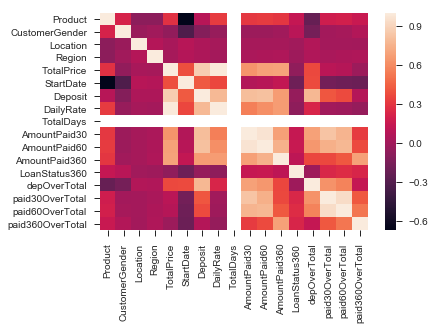

In [6]:
sns.heatmap(dat.corr())

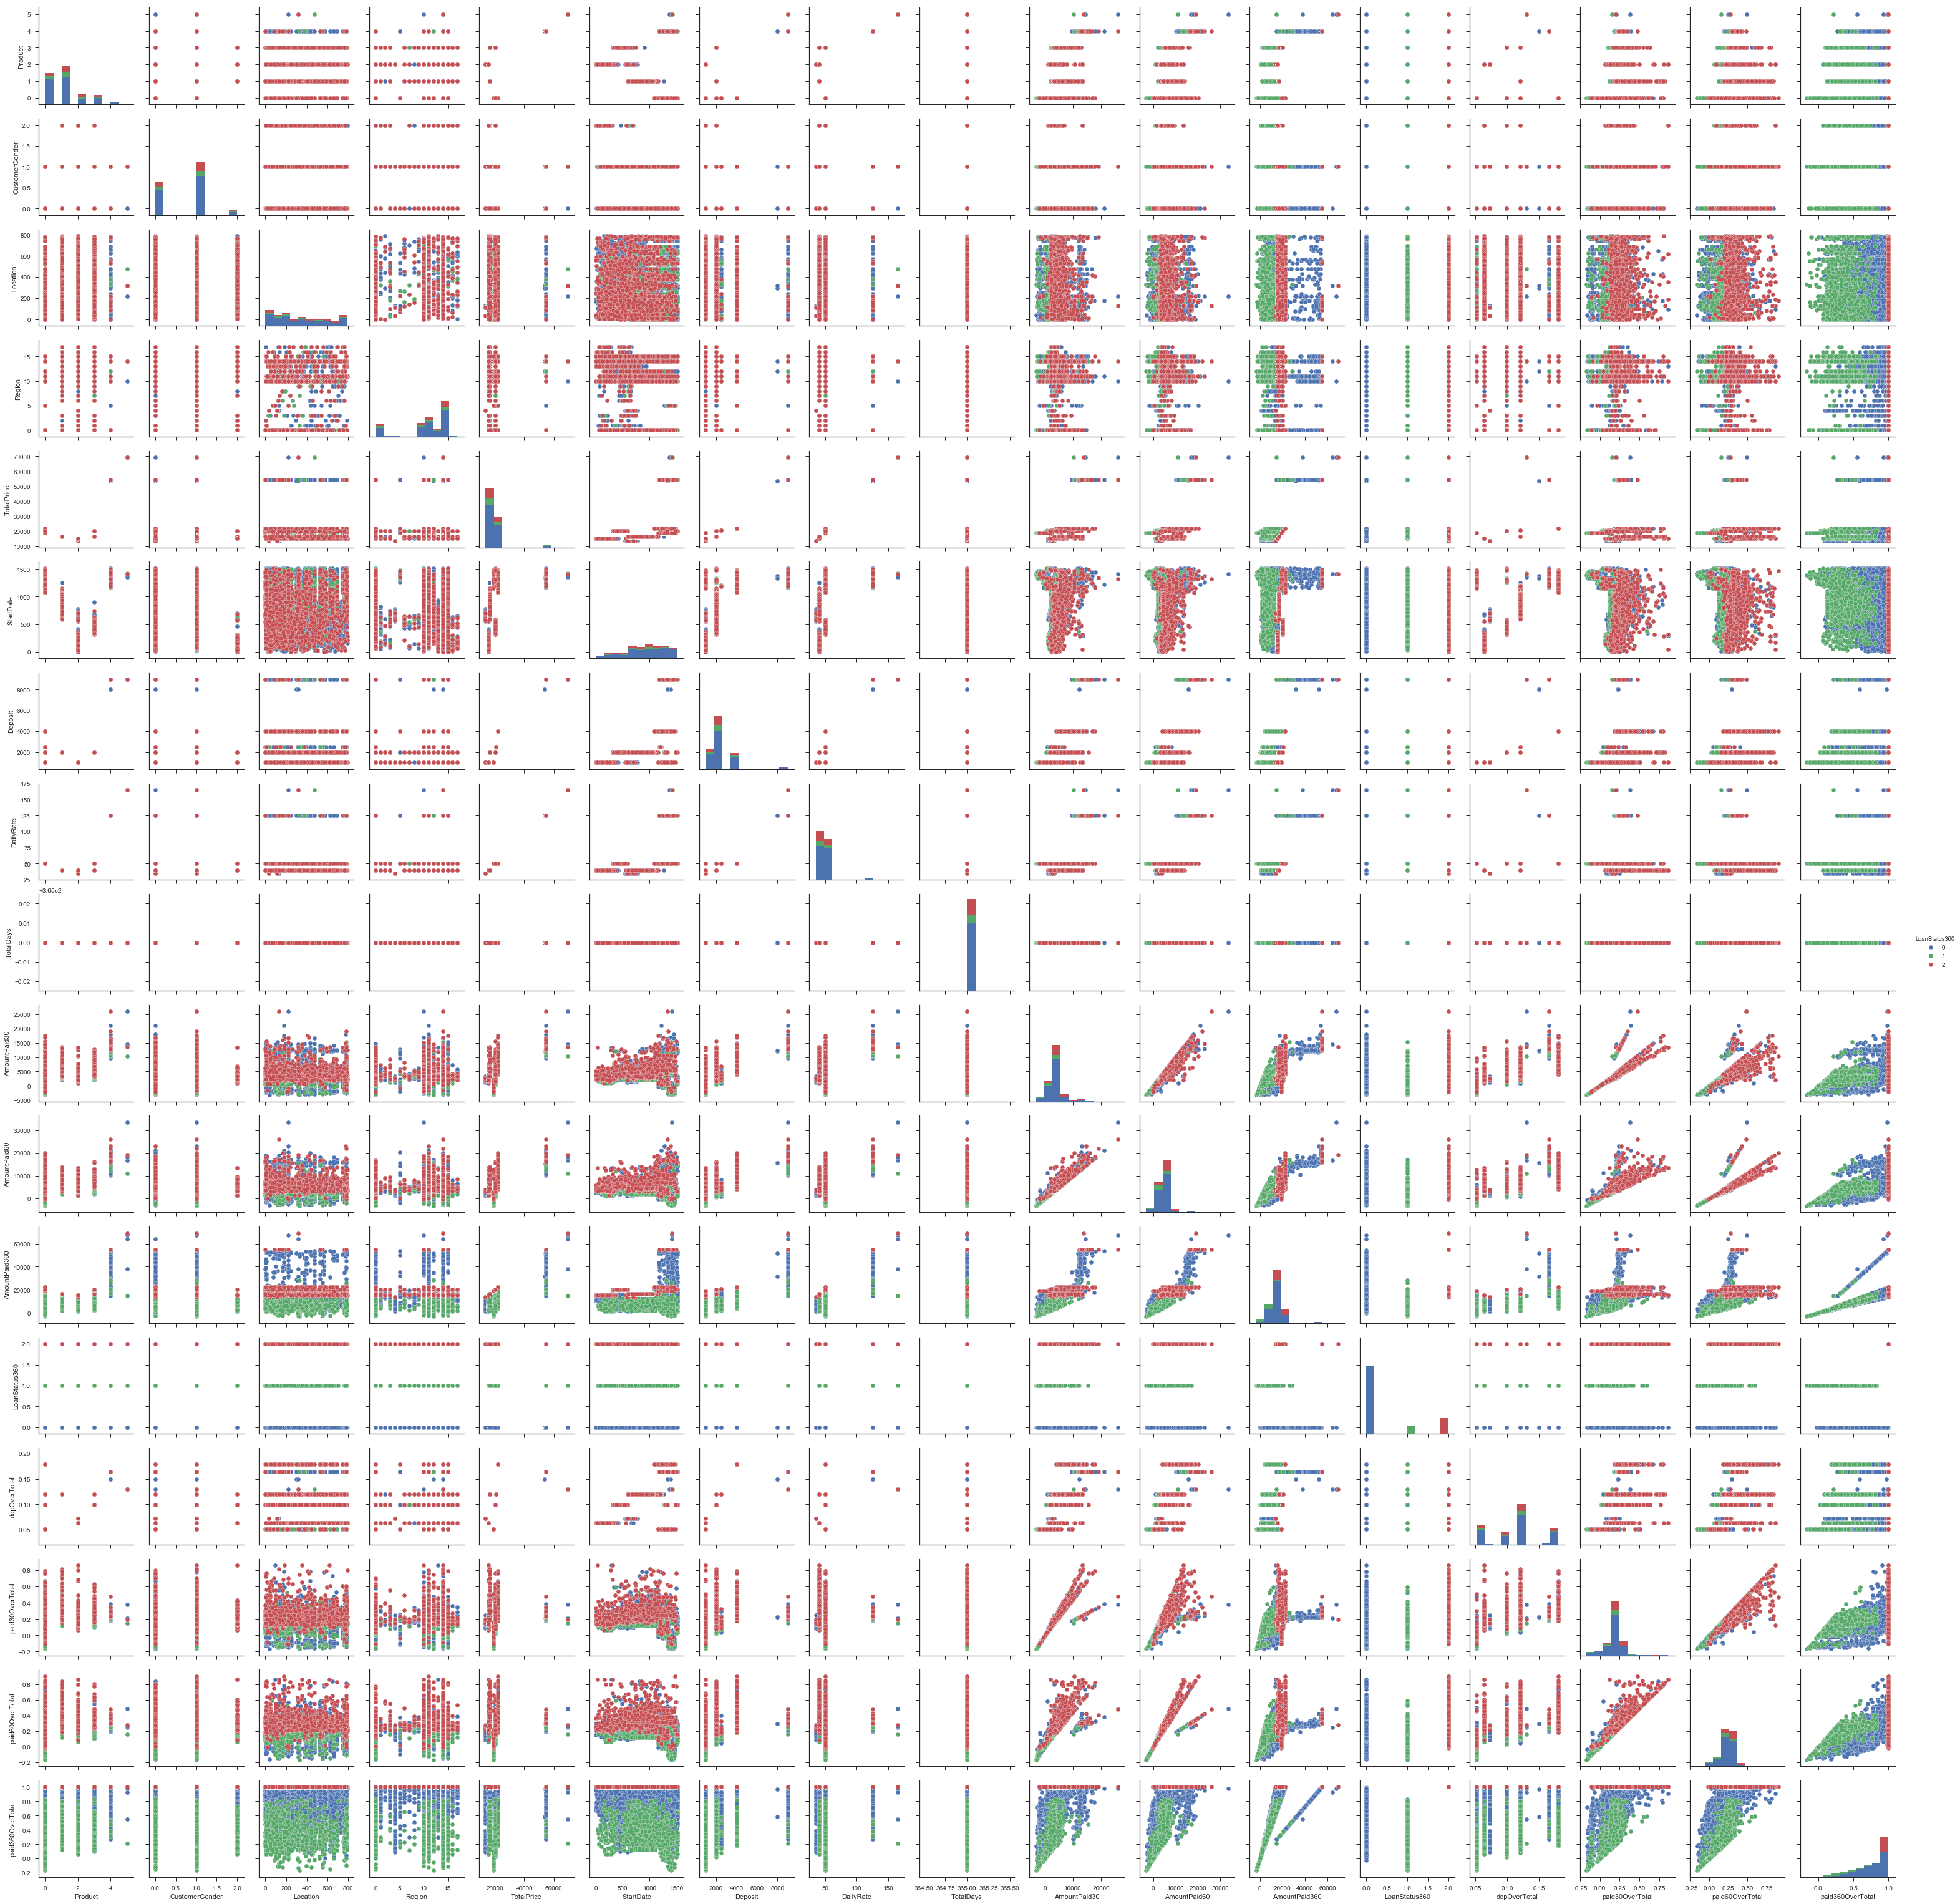

In [7]:
g = sns.pairplot(dat, hue="LoanStatus360")

In [8]:
#Split variable that is being predicted
X = dat.loc[:, dat.columns != 'AmountPaid360']
Y = pd.DataFrame(dat.AmountPaid360)
#Split data into train and test
Xtrain,Xtest,ytrain,ytest=train_test_split(X,Y, test_size=0.3, random_state=31)

In [11]:
# Number of trees in random forest
nEstimators = [int(x) for x in np.linspace(start = 500, stop = 1500, num = 5)]
# Number of features to consider at every split
maxFeatures = ['auto', 'sqrt']
# Maximum number of levels in tree
maxDepth = [int(x) for x in np.linspace(10, 100, num = 10)]
maxDepth.append(None)
# Minimum number of samples required to split a node
minSamplesSplit = [ 2, 5, 10]
# Minimum number of samples required at each leaf node
minSamplesLeaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
randomGrid = {'n_estimators': nEstimators,
               'max_features': maxFeatures,
               'max_depth': maxDepth,
               'min_samples_split': minSamplesSplit,
               'bootstrap': bootstrap}
print(randomGrid)
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, search across 100 different combinations, and use all available cores
rfRandom = RandomizedSearchCV(estimator = rf, param_distributions = randomGrid, n_iter = 5, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rfRandom.fit(Xtrain,ytrain)
rfRandom.best_params_

{'n_estimators': [500, 750, 1000, 1250, 1500], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'min_samples_split': [2, 5, 10], 'bootstrap': [True, False]}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  2.0min finished


{'bootstrap': True,
 'max_depth': 100,
 'max_features': 'auto',
 'min_samples_split': 2,
 'n_estimators': 500}

In [12]:
#Fit and predict Lasso
lasso = Lasso()
lasso.fit(Xtrain,ytrain)
lasso1 = lasso.predict(Xtest)

#Fit and predict simple Random Forest
simpleRF = RandomForestRegressor(n_estimators = 10, random_state = 42)
simpleRF.fit(Xtrain,ytrain)
rf1pred = pd.DataFrame(simpleRF.predict(Xtest))

#Fit and predict best Random Forest parameters from Random CV
bestRandom = rfRandom.best_estimator_
rf2pred = pd.DataFrame(bestRandom.predict(Xtest))

#Evaluate models
def evaluate(ytrue, ypred, mod):
    maxError = max_error(ytrue, ypred)
    MAE = mean_absolute_error(ytrue, ypred)
    MSE = mean_squared_error(ytrue, ypred)
    RMSE = sqrt(MSE)
    r2 = r2_score(ytrue, ypred)
    print("-----",mod, "-----")
    print('Model Performance')
    print('Max Error = {:0.2f}.'.format(maxError))
    print('Mean Absolute Error: {:0.2f}'.format(MAE))
    print('Mean Squared Error = {:0.2f}.'.format(MSE))
    print('Root Mean Squared Error = {:0.2f}.'.format(RMSE))
    print('R2 Score = {:0.2f}.'.format(r2))
    print('')
evaluate(ytest, lasso1, "Simple Lasso")
evaluate(ytest, rf1pred, "Simple Random Forest")
evaluate(ytest, rf2pred, "Random Grid Search Random Forest")


----- Simple Lasso -----
Model Performance
Max Error = 14716.90.
Mean Absolute Error: 527.16
Mean Squared Error = 1317170.98.
Root Mean Squared Error = 1147.68.
R2 Score = 0.97.

----- Simple Random Forest -----
Model Performance
Max Error = 22867.80.
Mean Absolute Error: 59.91
Mean Squared Error = 346939.92.
Root Mean Squared Error = 589.02.
R2 Score = 0.99.

----- Random Grid Search Random Forest -----
Model Performance
Max Error = 12390.37.
Mean Absolute Error: 49.18
Mean Squared Error = 160544.71.
Root Mean Squared Error = 400.68.
R2 Score = 1.00.



In [15]:
#Split variable that is being predicted
X1 = dat.loc[:, dat.columns != 'LoanStatus360']
Y1 = pd.DataFrame(dat.LoanStatus360)

#Split data into train and test
X1train,X1test,y1train,y1test=train_test_split(X1,Y1, test_size=0.3, random_state=31)

In [16]:
# KNN basic classifier
knn = KNeighborsClassifier()
knn.fit(X1train, y1train)
knn1pred = knn.predict(X1test)

#Logistic regression model
logreg = LogisticRegression()
logreg.fit(X1train, y1train)
logreg1pred = logreg.predict(X1test)

# Evaluate results
print("----- KNeighborsClassifier -----")
print(classification_report(y1test, knn1pred))
print("----- LogisticRegression -----")
print(classification_report(y1test, logreg1pred))

----- KNeighborsClassifier -----
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      2052
           1       0.83      0.60      0.70       253
           2       0.88      0.99      0.93       454

   micro avg       0.93      0.93      0.93      2759
   macro avg       0.89      0.85      0.86      2759
weighted avg       0.93      0.93      0.93      2759

----- LogisticRegression -----
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      2052
           1       0.83      0.46      0.59       253
           2       0.99      1.00      1.00       454

   micro avg       0.94      0.94      0.94      2759
   macro avg       0.92      0.81      0.85      2759
weighted avg       0.94      0.94      0.93      2759

